In [3]:
# setup
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import requests
import calendar
import geopandas as gpd
import os.path as os
import scipy.stats
import sys
import http.client, urllib.request, urllib.parse, urllib.error, base64
import config

from sklearn.model_selection import GridSearchCV

root= r"C:/Users/Jennah/Desktop/Code/machine-learning-final"
inp= os.join(root, "data", "3_clean")
interm= os.join(root, "data", "2_intermediate")

plots= os.join(root, "code", "plots")

In [4]:
from pydrive.auth import GoogleAuth

gauth = GoogleAuth()
gauth.LocalWebserverAuth() # Creates local webserver and auto handles authentication.

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=570719947456-53haph7mjc317oel1ujh0kmjbfd499jf.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


In [5]:
# files in clean data google drive
from pydrive.drive import GoogleDrive
drive = GoogleDrive(gauth)
fileList = drive.ListFile({'q': "'1jxSI_nq32-W9kPHKvQkzuNGJ5aIBD2j2' in parents and trashed=false"}).GetList()
for file in fileList:
  print('Title: %s, ID: %s' % (file['title'], file['id']))
  # Get the folder ID that you want
  if(file['title'] == "To Share"):
      fileID = file['id']

Title: analysis_bbl_noacs.csv, ID: 1h-tDpBSslfzqzsJe1ny_ujDnr68RKry3
Title: analysis_bbl.csv, ID: 1yYX-ROr1c7fzcQiG6NZ1sh7Ko5gqr_4G
Title: analysis_box.csv, ID: 1Vzjvta98IG9Hg4SfAGcd8JD8FaF3IXwy
Title: borobox_convex_hull.geojson, ID: 1SzBNj3Ba-v9MEwuCkZT9e9iAwVYUqx8r


## Load analysis file

In [6]:
df_box = drive.CreateFile({'id': '1Vzjvta98IG9Hg4SfAGcd8JD8FaF3IXwy'})
df_box.GetContentFile('analysis_box.csv')  

df_box= pd.read_csv('analysis_box.csv').drop(["Unnamed: 0"], axis = 1)
df_box.head()

,borobox,lotarea,bldgarea,numbldgs,numfloors,unitsres,unitstotal,assessland,assesstot,exempttot,...,pctnhhawainpi,pctnhother,pctnhtwoplus,pctownerocch,pctrentocch,engines_assigned_quantity,ladders_assigned_quantity,dispatch_response_seconds_qy,num_fire_ev,avg_fire_ev_yr
0,B0020,3457.956522,9239.391304,1.173913,3.521739,9.000000,9.043478,3.718826e+04,8.482943e+05,2.937391e+03,...,0.0,75.014132,3.109101,17.874693,82.125307,3.500000,2.333333,32.666667,6,1.200000
1,B0023,26081.875000,209572.375000,1.000000,18.750000,229.750000,231.125000,1.322048e+06,1.219295e+07,2.589945e+06,...,0.0,55.046167,4.567627,10.668339,89.331661,3.000000,2.000000,42.333333,3,3.000000
2,B0024,2754.847826,4832.108696,1.086957,3.217391,5.695652,5.847826,4.959654e+04,5.346010e+05,4.643715e+04,...,0.0,56.400742,4.842301,9.965636,90.034364,3.200000,2.040000,36.880000,25,1.923077
3,B0025,61653.000000,85292.250000,1.250000,10.750000,101.500000,102.000000,8.558175e+05,3.580575e+06,2.746800e+06,...,0.0,56.400742,4.842301,9.965636,90.034364,2.400000,1.600000,15.600000,5,1.666667
4,B0027,3888.574713,8242.965517,1.126437,3.183908,7.080460,7.402299,4.881548e+04,6.619610e+05,1.669940e+05,...,0.0,56.400742,4.842301,9.965636,90.034364,3.545455,2.340909,32.181818,44,2.933333


In [7]:
assert df_box.dropna().shape[0] == df_box.shape[0]

In [8]:
df_box.columns
predictors = ["lotarea", "bldgarea", "numbldgs", "numfloors", "unitsres", "unitstotal", "assessland",
             "assesstot", "exempttot", "yearbuilt", "holc_AB", "holc_CD", "holc_D",
             "tot_hpd_vio", "hpd_fire_vio", "hpd_b_c_vio",
             "viol_count_per_unit", "hpd_fire_vio_per_unit", "hpd_b_c_vio_per_unit",
             "AL", "NB", "average_energy_usage", "average_energy_usage_mi"]

predictors_acs= df_box.columns[df_box.columns.get_loc("totpop"):df_box.columns.get_loc("pctrentocch") + 1].tolist()
landusecols= [x for x in df_box.columns if x in 'landuse_']
bldgclasscols= [x for x in df_box.columns if x in 'bldgclass_']

predictors_full= predictors + predictors_acs  + landusecols + bldgclasscols
predictors_full;

In [9]:
outcomes= ["dispatch_response_seconds_qy", "num_fire_ev", "avg_fire_ev_yr"]
df_box[outcomes].head()

,dispatch_response_seconds_qy,num_fire_ev,avg_fire_ev_yr
0,32.666667,6,1.200000
1,42.333333,3,3.000000
2,36.880000,25,1.923077
3,15.600000,5,1.666667
4,32.181818,44,2.933333


# (0) Prep data

In [10]:
df_box.describe()

,lotarea,bldgarea,numbldgs,numfloors,unitsres,unitstotal,assessland,assesstot,exempttot,yearbuilt,...,pctnhhawainpi,pctnhother,pctnhtwoplus,pctownerocch,pctrentocch,engines_assigned_quantity,ladders_assigned_quantity,dispatch_response_seconds_qy,num_fire_ev,avg_fire_ev_yr
count,1.086400e+04,1.086400e+04,10864.000000,10864.000000,10864.000000,10864.000000,1.086400e+04,1.086400e+04,1.086400e+04,10864.000000,...,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000
mean,1.357522e+04,2.571084e+04,1.933247,3.265942,24.319713,24.943418,2.715792e+05,1.459393e+06,6.523947e+05,1936.620042,...,0.033584,35.968794,1.990526,45.008986,54.991014,2.696305,1.891626,40.335653,27.951859,2.381331
std,1.175372e+05,1.833891e+05,13.499644,3.536401,175.050922,176.069510,1.863966e+06,8.148841e+06,6.698656e+06,62.844576,...,0.199652,29.433936,1.842385,26.257344,26.257344,1.179745,0.752555,18.500212,48.572309,2.800509
min,5.262012e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,3.473684e+03,1.869000e+04,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2.657231e+03,1.837039e+03,1.066667,2.003120,1.414634,1.448040,1.375180e+04,4.607525e+04,2.226809e+03,1925.107672,...,0.000000,6.367742,0.657641,22.841801,30.907842,2.090909,1.571429,32.290179,5.000000,1.200000
50%,3.586508e+03,2.774481e+03,1.218750,2.280000,2.367664,2.517241,2.153047e+04,8.708528e+04,4.093244e+03,1938.104409,...,0.000000,31.129168,1.558296,43.404735,56.595265,2.909091,2.000000,40.333333,13.000000,1.666667
75%,5.214915e+03,8.144752e+03,1.464286,3.000000,7.698662,8.206375,5.787226e+04,3.684127e+05,3.452681e+04,1953.518519,...,0.000000,62.464689,2.783891,69.092158,77.158199,3.312500,2.250000,49.910985,31.000000,2.538462
max,7.921386e+06,1.354011e+07,1169.000000,72.000000,10914.000000,10948.000000,1.345064e+08,4.435560e+08,4.435560e+08,2021.000000,...,4.463191,100.000000,12.851406,100.000000,100.000000,23.928571,13.500000,450.000000,1288.000000,80.500000


In [11]:
df_box.loc[df_box["avg_fire_ev_yr"]==0].shape[0]/df_box.shape[0]

0.0625920471281296

In [12]:
# assert no missingness
assert (df_box.isna().sum(axis = 0).sum() == 0)

In [13]:
df_box_clean= df_box.dropna(how = "any")
df_box_clean.shape

(10864, 79)

In [132]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

X = df_box_clean.loc[:, predictors_full]
y = df_box_clean.loc[X.index, outcomes]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=999)

### Running LASSO to determine important variables

In [146]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_scaled, y, test_size=0.3, random_state=999)

In [147]:
from sklearn import linear_model

coef_comp= pd.DataFrame(X.columns, columns = ['Features'])
coef_comp

param_grid= {'alpha':[.00001, 0.0001,0.001, 0.01, 0.5, 1, 1.5, 2]}
clf= linear_model.Lasso(fit_intercept = True)
gr = GridSearchCV(clf, param_grid=param_grid, n_jobs=-1)
rs = gr.fit(X_train_l, y_train_l.iloc[:, 1])

print(rs.best_params_)
print(rs.best_score_)

clf= linear_model.Lasso(fit_intercept = True, alpha = rs.best_params_['alpha'])
clf.fit(X_train_l, y_train_l.iloc[:, 1])
coef_comp['coef_alpha_0.5']= clf.coef_

{'alpha': 0.5}
0.2650733133512092


In [148]:
clf= linear_model.Lasso(fit_intercept = True, alpha = 3)
clf.fit(X_train_l, y_train_l.iloc[:, 1])

# feature selection from LASSOs
# fewer features chosen
coef_comp['coef_alpha_3']= clf.coef_
lasso_coef= coef_comp.loc[coef_comp['coef_alpha_0.5'] != 0].sort_values('coef_alpha_0.5', ascending = False)
lasso_coef

,Features,coef_alpha_0.5,coef_alpha_3
24,popdens,8.285677e+00,6.112342e+00
56,gini,4.529184e+00,4.544167e+00
14,hpd_fire_vio,4.509975e+00,3.928791e+00
34,popnhblack,4.122506e+00,4.907743e+00
16,viol_count_per_unit,3.676672e+00,3.814805e+00
64,pctnhblack,2.747430e+00,9.509794e-01
3,numfloors,2.350446e+00,2.221795e-02
49,roc_half_1,1.860158e+00,0.000000e+00
10,holc_AB,1.464633e+00,0.000000e+00
12,holc_D,1.017947e+00,0.000000e+00


# (1) Decision Trees and Random Forest Models
* All are negative, suggests the model isn't performing very well

In [24]:
from sklearn.metrics import mean_squared_error
for c in range(3):
    print("\nDecision tree for", outcomes[c])
    print()
    
    dt1 = DecisionTreeRegressor(max_depth=10, random_state = 99)
    dt1.fit(X_train, y_train.iloc[:, c])

    dt2 = DecisionTreeRegressor(max_depth=15, random_state = 99)
    dt2.fit(X_train, y_train.iloc[:, c])

    y_pred1= dt1.predict(X_test)
    y_pred2= dt2.predict(X_test)

    print("R2 for model 1:", dt1.score(X_test, y_test.iloc[:, c]))
    print("R2 for model 2:", dt2.score(X_test, y_test.iloc[:, c]))
    
    print("\nMSE for model 1:", mean_squared_error(y_test.iloc[:, c], y_pred1))
    print("MSE for model 2:", mean_squared_error(y_test.iloc[:, c], y_pred2))


Decision tree for dispatch_response_seconds_qy

R2 for model 1: -0.1735561936872565
R2 for model 2: -0.3847496166225406

MSE for model 1: 436.6333260213812
MSE for model 2: 515.209952505999

Decision tree for num_fire_ev

R2 for model 1: -0.3848755766080205
R2 for model 2: -0.4439367660361757

MSE for model 1: 3508.6280185616865
MSE for model 2: 3658.2614928877765

Decision tree for avg_fire_ev_yr

R2 for model 1: -0.6204544598105766
R2 for model 2: -0.8131413450170046

MSE for model 1: 13.856398992851025
MSE for model 2: 15.504051813913367


## Tuning
* There is a higher R2 for num_fire_ev and avg_fire_ev_yr
* Seems to do well with a simpler model

In [25]:
# use max_depth to control the complexity of the tre
param_grid = {'max_depth':np.arange(1, 50, 2)}
bp= []
s= []
for c in range(3):
    dt=DecisionTreeRegressor()
    gr=GridSearchCV(dt,param_grid=param_grid)
    rs=gr.fit(X_train,y_train.iloc[:, c])
    
    bp+= [rs.best_params_]
    s+= [rs.score(X_test, y_test.iloc[:, c])]
    
    print("\nTuning decision tree for", outcomes[c])
    print(rs.best_params_)
    print(rs.score(X_test, y_test.iloc[:, c]))


Tuning decision tree for dispatch_response_seconds_qy
{'max_depth': 3}
0.026286876310595564

Tuning decision tree for num_fire_ev
{'max_depth': 3}
0.19561792313343251

Tuning decision tree for avg_fire_ev_yr
{'max_depth': 3}
0.13339393226280116


In [26]:
# the R2 is pretty low...
print(bp)
print(s)

[{'max_depth': 3}, {'max_depth': 3}, {'max_depth': 3}]
[0.026286876310595564, 0.19561792313343251, 0.13339393226280116]


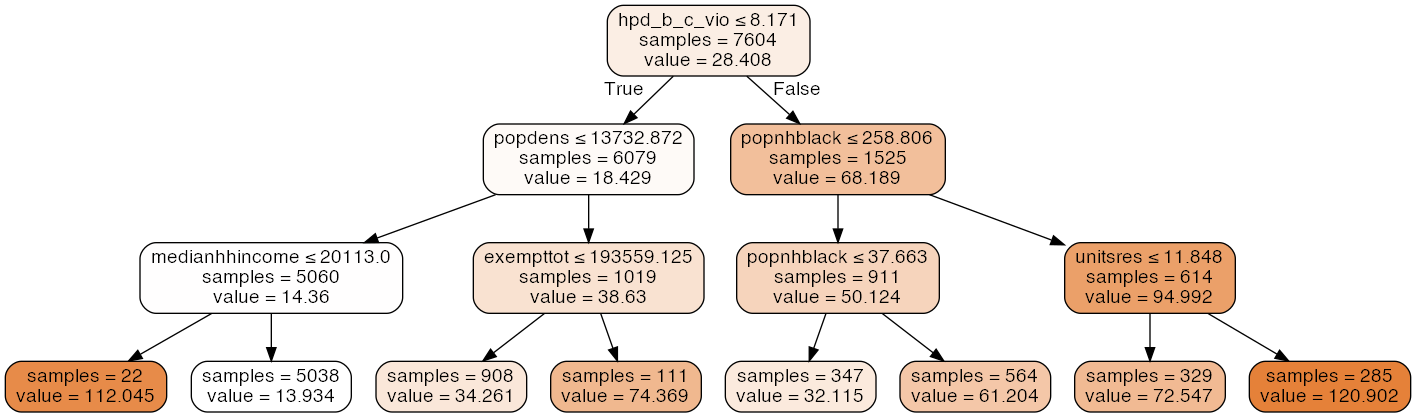

In [27]:
## can we visualize the decision tree?
## for num_fire_ev
from sklearn import tree
from IPython.display import Image  
import pydotplus

dt = DecisionTreeRegressor(max_depth= 3, random_state = 99) #bp[1]['max_depth']) # since max depth is optimal for 3, use that
dt.fit(X_train,y_train.iloc[:, 1])

thestring = tree.export_graphviz(dt, out_file=None,  
                         feature_names=X_train.columns.values, 
                         filled=True, rounded=True,  
                         special_characters=True,impurity=False).replace(" ;\n}", " ;}")
graph = pydotplus.graph_from_dot_data(thestring);
graph.write_png(os.join(plots,'num_fire_ev_dt.png'))
Image(graph.create_png())

## Feature Importance

In [28]:
dt = DecisionTreeRegressor(max_depth=rs.best_params_['max_depth'], random_state = 99)
dt.fit(X_train, y_train)
Feature_importance=pd.DataFrame([list(X_train.columns),list(dt.feature_importances_)]).T
Feature_importance.columns=["variables","importance"]

# list the top 10 most importnat features in order (using max_depth = 10)
ft1= Feature_importance.sort_values(by="importance",ascending=False).iloc[:10,:]
ft1

,variables,importance
13,tot_hpd_vio,0.576959
34,popnhblack,0.184019
4,unitsres,0.081143
5,unitstotal,0.067915
55,medianhhincome,0.048554
24,popdens,0.04141
48,roc_halfless,0.0
53,medianyearbuilt,0.0
52,roc_2plus,0.0
51,roc_onehalf_2,0.0


In [29]:
dt = DecisionTreeRegressor(max_depth=4, random_state = 99)
dt.fit(X_train, y_train)
Feature_importance=pd.DataFrame([list(X_train.columns),list(dt.feature_importances_)]).T
Feature_importance.columns=["variables","importance"]

# list the top 10 most important features in order (using max_Depth = 4)
ft2= Feature_importance.sort_values(by="importance",ascending=False).iloc[:10,:]
ft2

,variables,importance
13,tot_hpd_vio,0.473566
34,popnhblack,0.174077
55,medianhhincome,0.112174
4,unitsres,0.082084
5,unitstotal,0.055745
24,popdens,0.039617
65,pctnhaian,0.037453
14,hpd_fire_vio,0.018099
41,housingoccupied,0.007185
52,roc_2plus,0.0


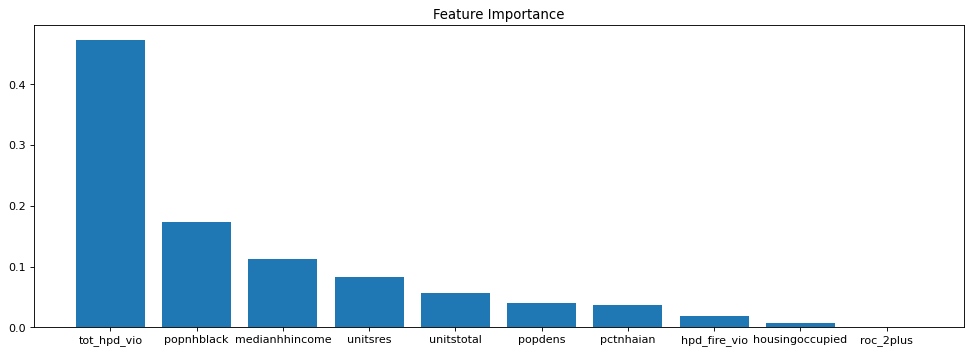

In [30]:
plt.figure(figsize=(15, 5), dpi=80)
plt.bar(ft2.sort_values(by="importance",ascending=False).iloc[:,0],
        ft2.sort_values(by="importance",ascending=False).iloc[:,1])
plt.title("Feature Importance");

## Random Forests
* Only outcome is number of num_fire_ev

In [31]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=30, n_jobs=-1, max_depth = 4, random_state = 99)
rf.fit(X_train, y_train.iloc[:, 1])
y_pred=rf.predict(X_test)
print("R2 with random forest:", rf.score(X_test, y_test.iloc[:, 1]))

R2 with random forest: 0.22910003624762132


In [32]:
param_grid = {'max_depth':range(1,30)}
rf = RandomForestRegressor(n_jobs=-1, n_estimators=30, random_state = 99)
gs = GridSearchCV(rf,param_grid=param_grid)
rs = gs.fit(X_train,y_train.iloc[:, 1])
y_pred= rs.predict(X_test)

print(rs.best_params_)
print("R2 with best paramters:", rs.score(X_test, y_test.iloc[:, 1]))

{'max_depth': 6}
R2 with best paramters: 0.20743907461649091


### CMM Method and Other Ensemble Methods
* [From Domingos, 1998](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.40.2710&rep=rep1&type=pdf)
* Not much of an increase in accuracy compared to decision tree model

In [44]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=30, random_state = 99, max_depth = 6) #rs.best_params_['max_depth'])
rf.fit(X_train,y_train.iloc[:, 1])

# randomly generate a sample of xs
X_rand= pd.DataFrame({x:X_train[x].sample(n = round(0.5*X_train.shape[0])).reset_index(drop = True) for x in X_train.columns})
y_rand= rf.predict(X_rand)

In [45]:
# create the cmm training datasets
X_train_cmm= pd.concat([X_rand, X_train], axis = 0, ignore_index = True)
y_train_cmm= pd.concat([round(pd.DataFrame(y_rand)), y_train.iloc[:, 1]], axis = 0, ignore_index = True)

In [46]:
param_grid = {'max_depth':range(1,30)}
dt=DecisionTreeRegressor()
gr=GridSearchCV(dt,param_grid=param_grid)
rs=gr.fit(X_train_cmm, y_train_cmm)

print(rs.best_params_)
print(rs.score(X_test, y_test.iloc[:, 1]))

{'max_depth': 3}
0.17877827140813074


In [47]:
## prediction
pred = rs.predict(X_test)
pred;

In [48]:
dt = DecisionTreeRegressor(max_depth= 3, random_state = 99) #rs.best_params_['max_depth']) # since max depth is optimal for 3, use that
dt.fit(X_train_cmm, y_train_cmm)

DecisionTreeRegressor(max_depth=3, random_state=99)

In [49]:
Feature_importance=pd.DataFrame([list(X_train_cmm.columns),list(dt.feature_importances_)]).T
Feature_importance.columns=["variables","importance"]

# list the top 10 most importnat features in order (using max_depth = 10)
ft3= Feature_importance.sort_values(by="importance",ascending=False)
ft3.loc[ft3['importance']>0]

,variables,importance
15,hpd_b_c_vio,0.628034
34,popnhblack,0.142548
24,popdens,0.131399
14,hpd_fire_vio,0.074441
60,pct35_64,0.023578


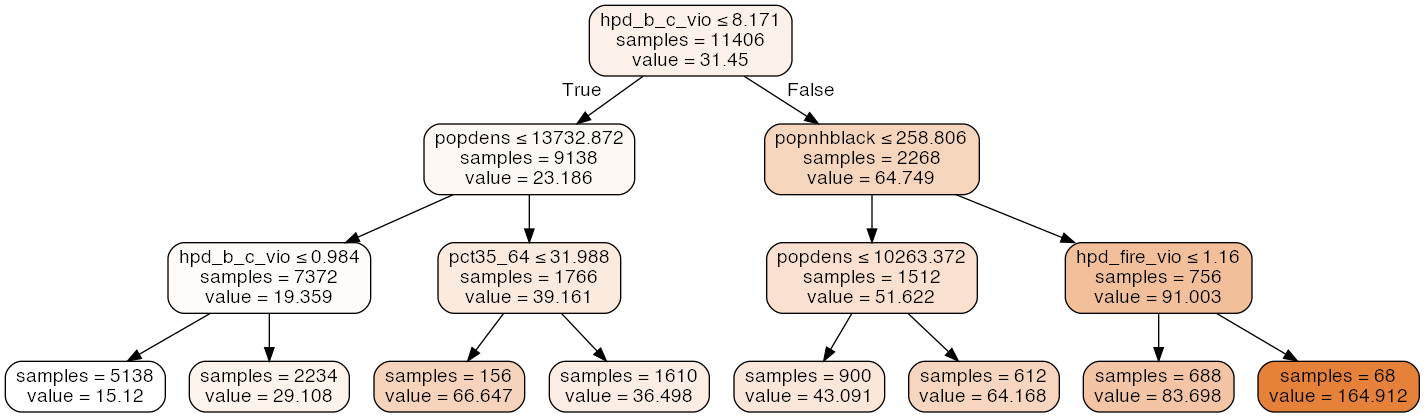

In [50]:
## we can plot this
from sklearn import tree
from IPython.display import Image  
import pydotplus

thestring = tree.export_graphviz(dt, out_file=None,  
                         feature_names=X_train.columns.values, 
                         filled=True, rounded=True,  
                         special_characters=True,impurity=False).replace(" ;\n}", " ;}")
graph = pydotplus.graph_from_dot_data(thestring);
graph.write_png(os.join(plots,'num_fire_ev_cmm.png'))
Image(graph.create_png())

# (2) Bayes Nets

In [220]:
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import K2Score, BicScore, BDeuScore
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator
import matplotlib.pyplot as plt

In [221]:
## need to discretize outcomes
df_box_disc= df_box.copy()

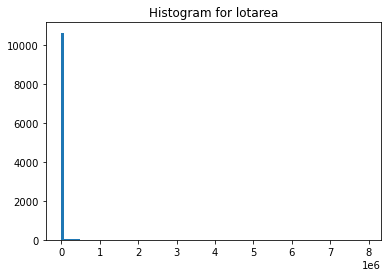

None


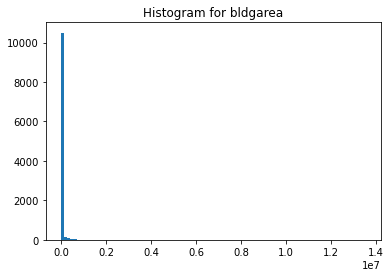

None


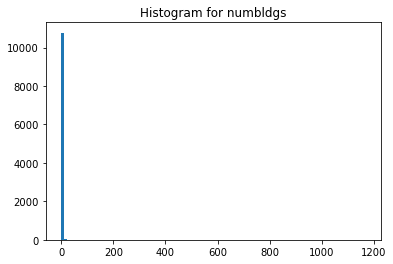

None


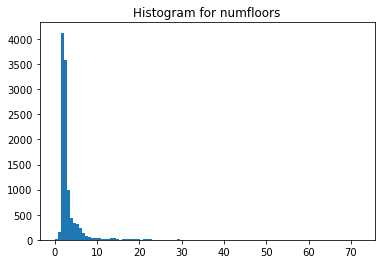

None


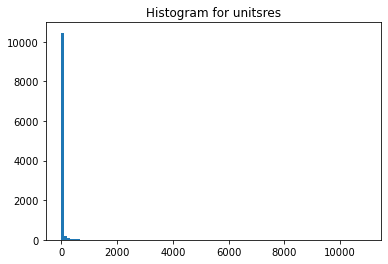

None


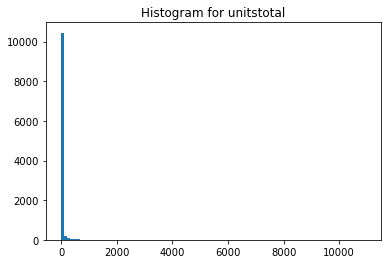

None


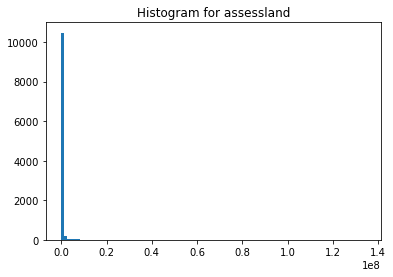

None


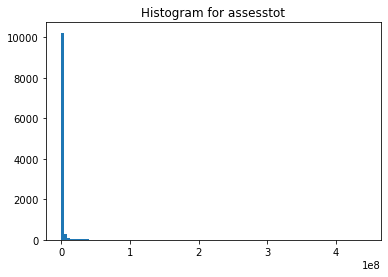

None


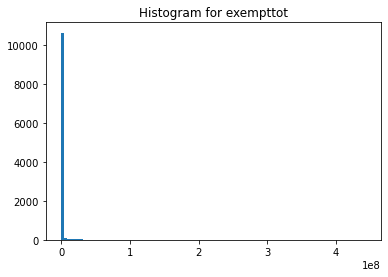

None


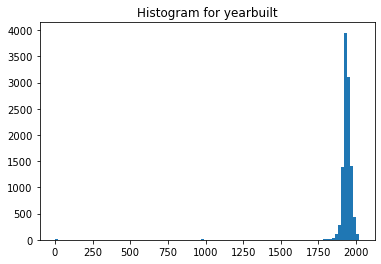

None


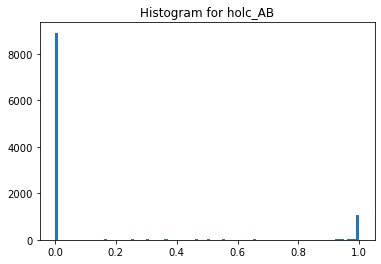

None


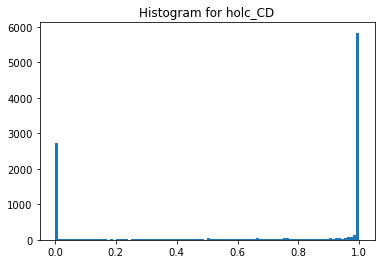

None


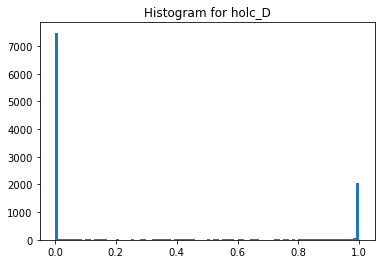

None


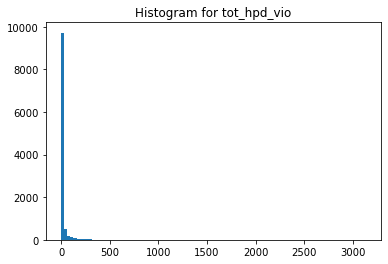

None


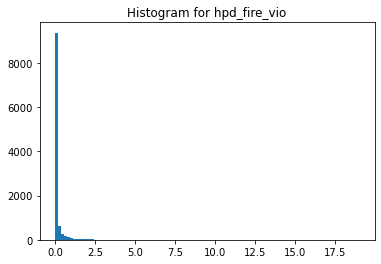

None


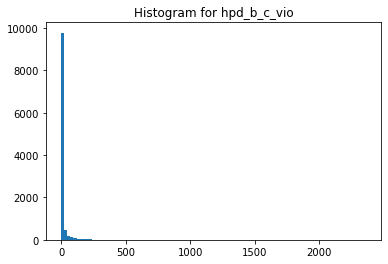

None


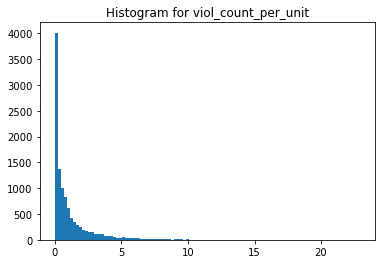

None


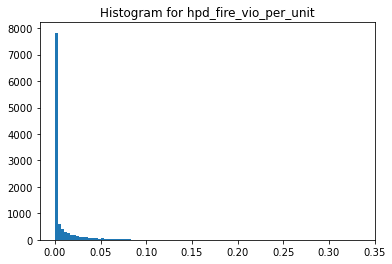

None


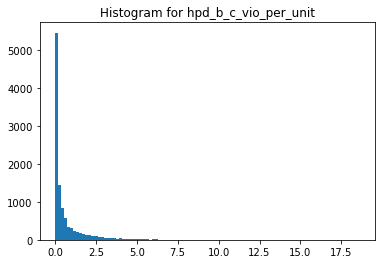

None


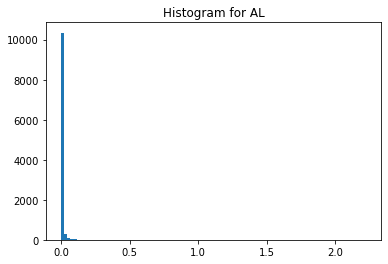

None


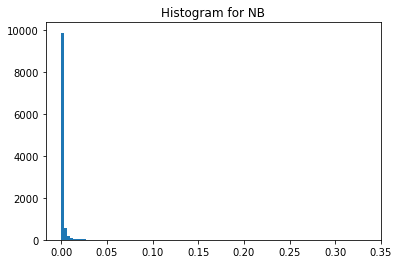

None


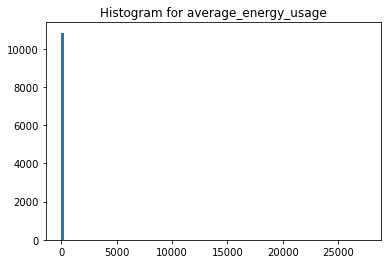

None


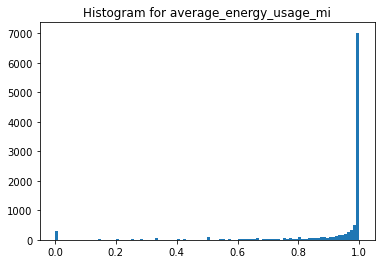

None


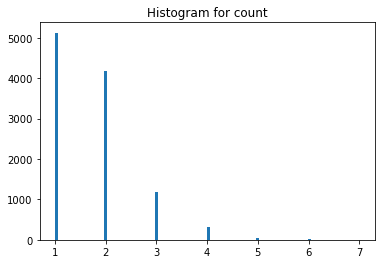

None


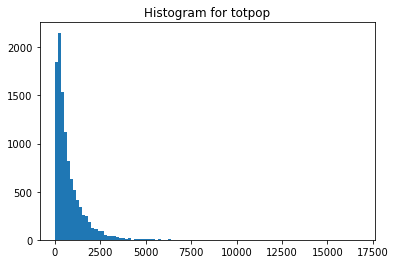

None


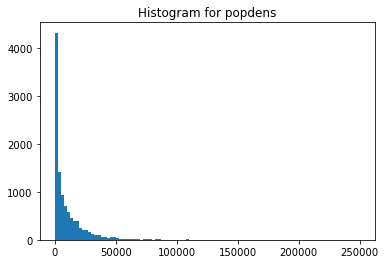

None


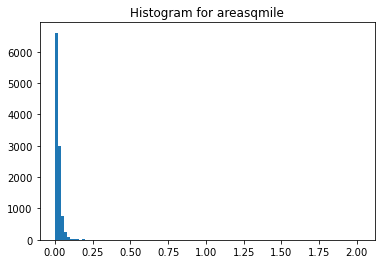

None


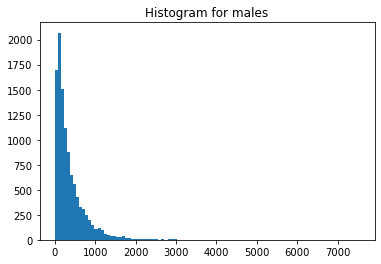

None


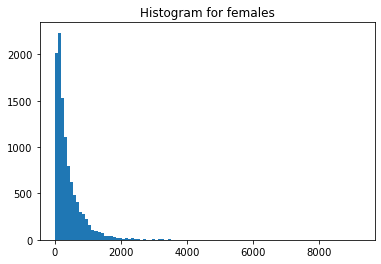

None


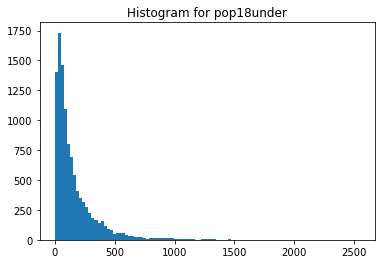

None


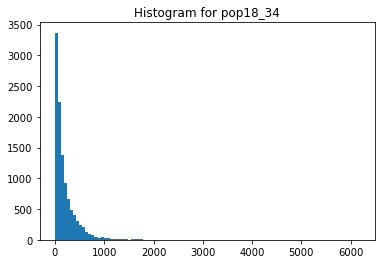

None


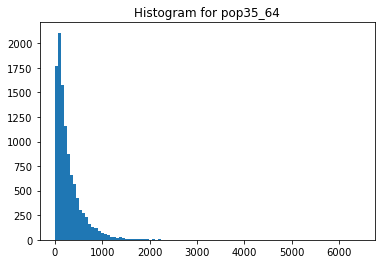

None


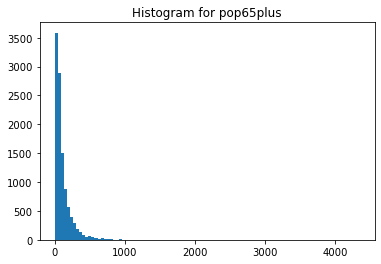

None


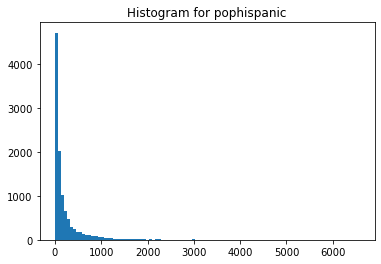

None


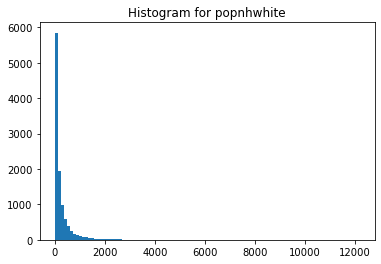

None


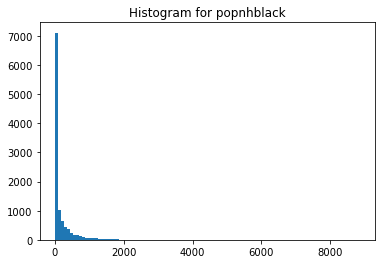

None


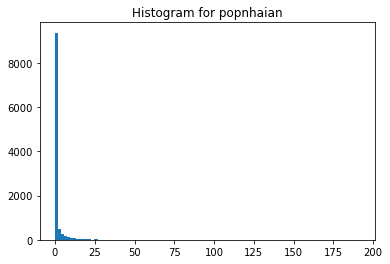

None


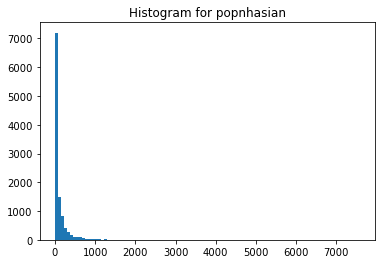

None


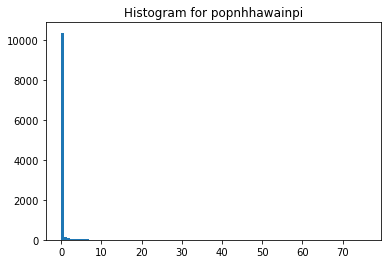

None


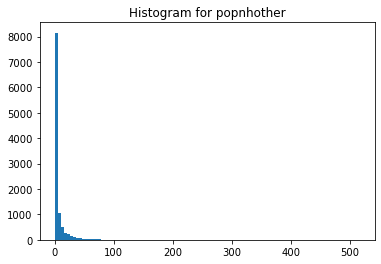

None


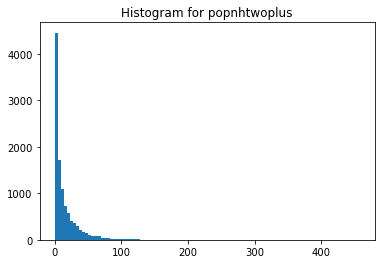

None


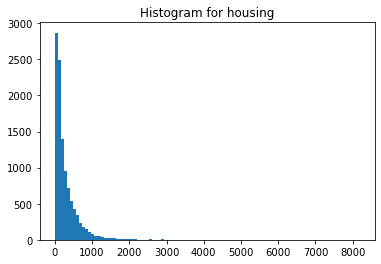

None


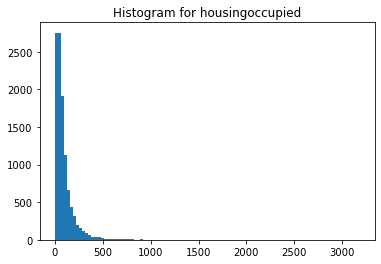

None


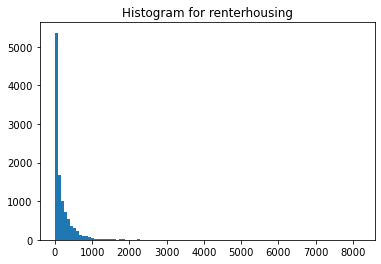

None


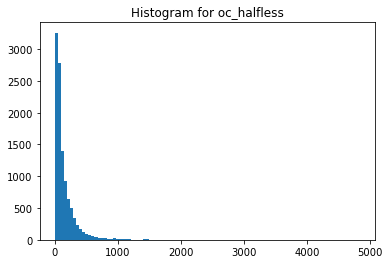

None


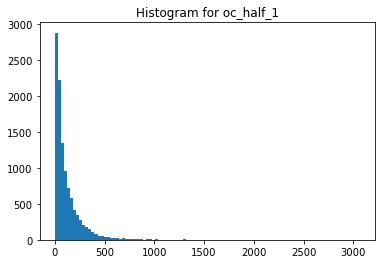

None


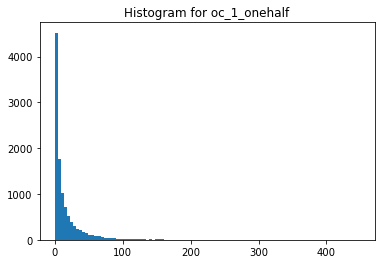

None


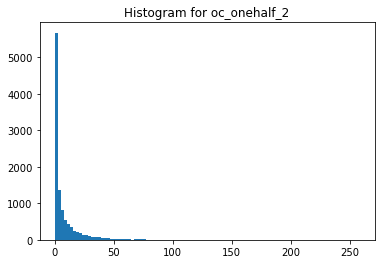

None


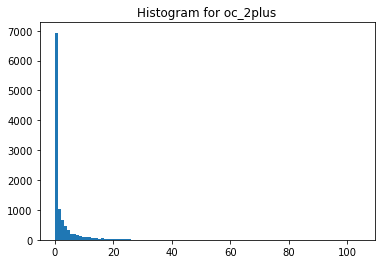

None


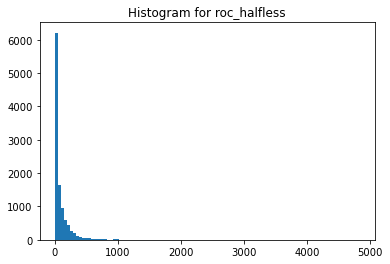

None


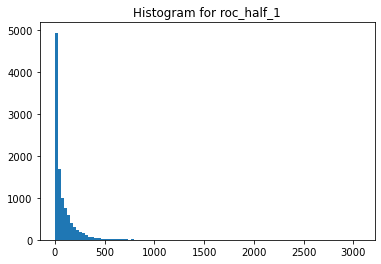

None


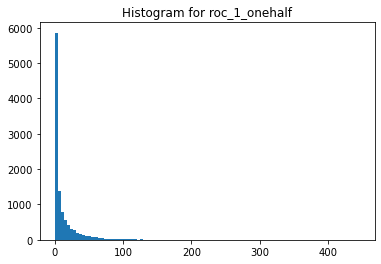

None


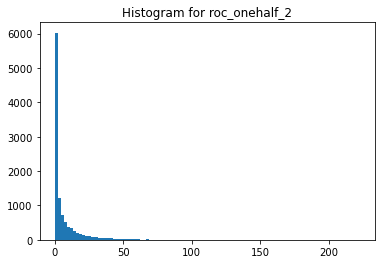

None


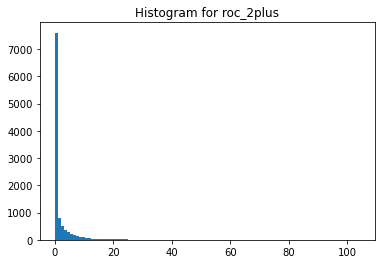

None


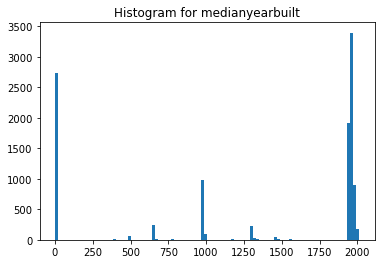

None


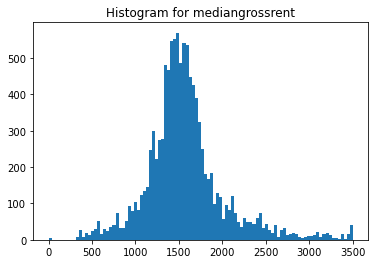

None


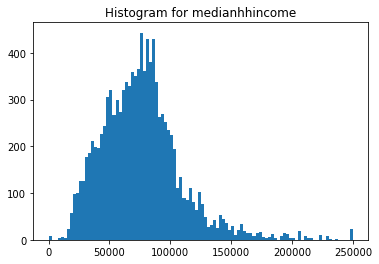

None


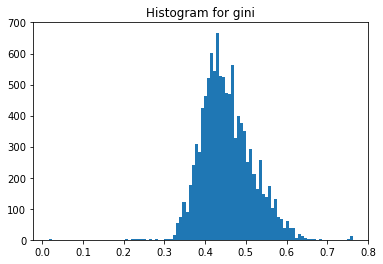

None


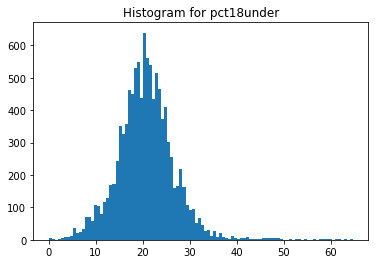

None


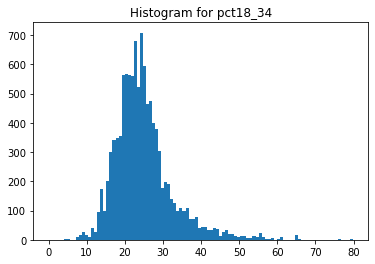

None


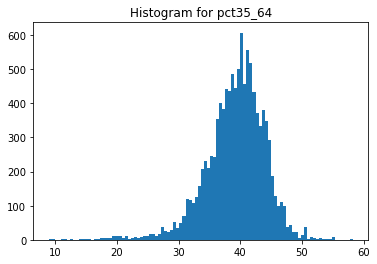

None


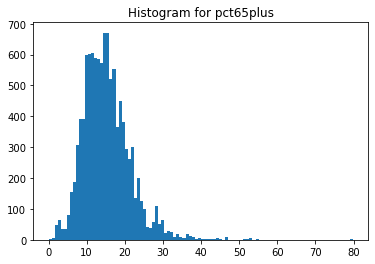

None


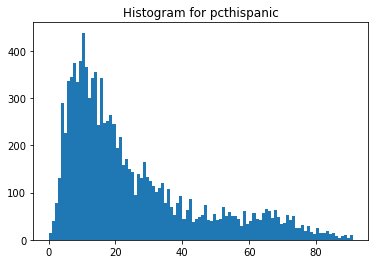

None


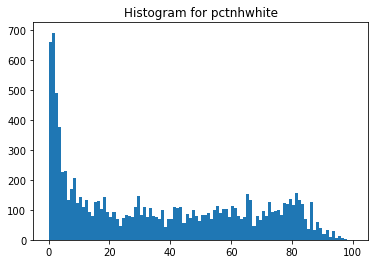

None


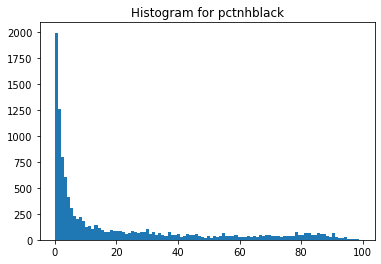

None


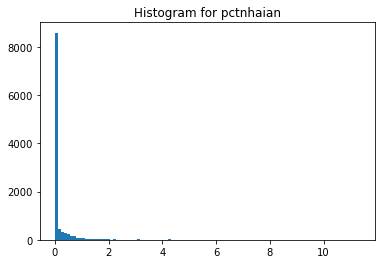

None


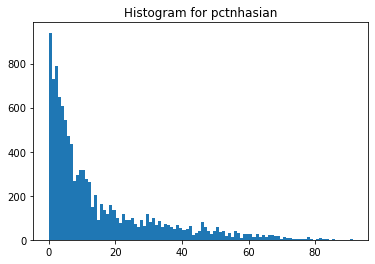

None


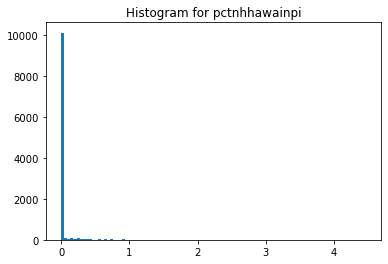

None


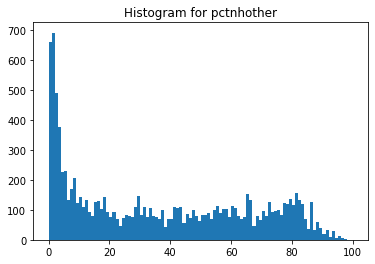

None


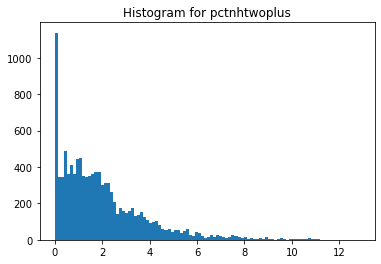

None


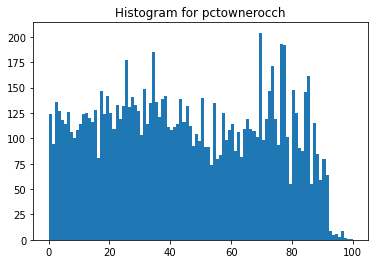

None


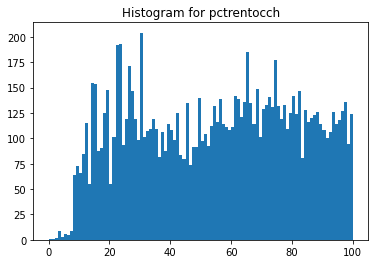

None


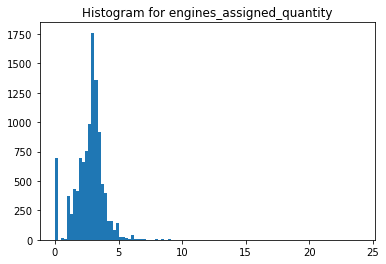

None


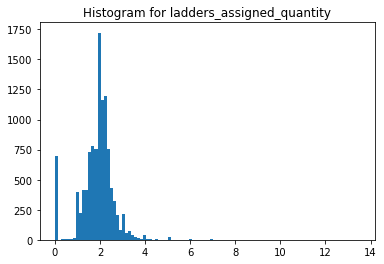

None


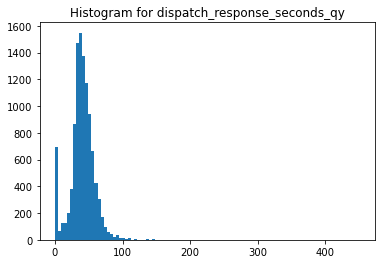

None


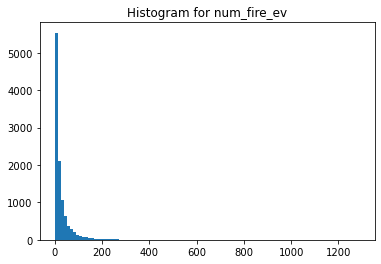

None


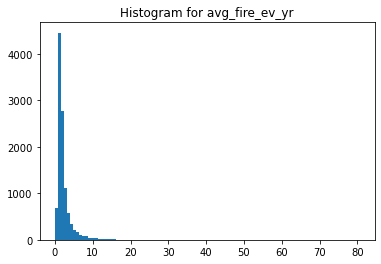

None


In [222]:
# discretize each variable to four equal-frequency bins (quartiles)
for i in df_box_disc.columns[1:]:
    if len(df_box_disc.loc[:, i].unique()) > 5:
        plt.hist(df_box_disc.loc[:, i], bins = 100);
        plt.title("Histogram for {}".format(i))
        print(plt.show())
        df_box_disc.loc[:, i] = pd.qcut(df_box_disc.loc[:, i], q=4, labels=False, duplicates = 'drop')

In [223]:
## important vars
#impt_vars= outcomes[0:2] + ft2["variables"].tolist()
#impt_vars= outcomes[0:2] + ['hpd_b_c_vio', 'bldgarea', 'unitsres', 'pctnhblack', 'pcthispanic',
#                            'hpd_fire_vio', 'holc_D', 'NB', 'AL', 'popdens', 'medianhhincome', 'pct65plus',
#                            'pctownerocch', 'pctrentocch', 'crowdingrenter'] #ft.loc[ft['importance']>0, "variables"].tolist()
impt_vars= outcomes[0:2] + ft1.loc[ft1['importance']>0, "variables"].tolist()
impt_vars

NameError: name 'ft1' is not defined

In [ ]:
# create test train split for testing DAG
train, test = train_test_split(df_box_disc.loc[:, impt_vars], test_size=0.3, random_state=999)

In [ ]:
# use hill climb search with BIC score, as in hw
hc = HillClimbSearch(train)
best_model = hc.estimate(scoring_method=BicScore(train))
print("\nDAG model edges:")
print(best_model.edges())

In [ ]:
print("DAG model nodes:")
print(best_model.nodes())

In [ ]:
# look at the CPD for the model
model = BayesianNetwork(best_model.edges())
model.fit(train.loc[:, impt_vars], estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=10)
for cpd in model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)
for n in model.nodes():
    print(model.local_independencies(n))

In [ ]:
import networkx as nx
import pylab as plt
fig = plt.gcf()

values = ['red' if n in ['num_fire_ev', 'dispatch_response_seconds_qy'] else 'lightblue' for n in model.nodes()]
# use networkx to draw DAG
nx.draw(model, node_color=values, with_labels=True, font_color='black', node_size=200,font_size=10)

plt.figure(figsize = (12,10))
fig.savefig('dag_.png')

In [ ]:
pred = model.predict(test.loc[:, [n for n in model.nodes() if n not in ['num_fire_ev', 'dispatch_response_seconds_qy']]])
print(pred)

In [ ]:
for i in impt_vars[0:2]:
    print("\nOS accuracy for: {}".format(i))
    print((pred[i].reset_index(drop = True) == test[i].reset_index(drop = True)).mean())

In [ ]:
# prediction just for time to the fire
pred = model.predict(test.loc[:, [n for n in model.nodes() if n not in ['dispatch_response_seconds_qy']]], stochastic = True)
print(pred)

In [78]:
print("\nOS accuracy time to the fire, includes num_fire_ev as predictor")
print((pred['dispatch_response_seconds_qy'].reset_index(drop = True) == test['dispatch_response_seconds_qy'].reset_index(drop = True)).mean())


OS accuracy time to the fire, includes num_fire_ev as predictor
0.30920245398773005


### Re-run Bayes Net with Feature Selection from LASSO

In [224]:
impt_vars= outcomes[0:2] + lasso_coef.loc[lasso_coef["coef_alpha_3"] != 0, "Features"].tolist()

In [225]:
# create test train split for testing DAG
train, test = train_test_split(df_box_disc.loc[:, impt_vars], test_size=0.3, random_state=999)

In [226]:
# use hill climb search with BIC score, as in hw
hc = HillClimbSearch(train)
best_model = hc.estimate(scoring_method=BicScore(train))
print("\nDAG model edges:")
print(best_model.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]


DAG model edges:
[('num_fire_ev', 'dispatch_response_seconds_qy'), ('popdens', 'num_fire_ev'), ('popdens', 'pctnhblack'), ('popdens', 'popnhblack'), ('hpd_fire_vio', 'num_fire_ev'), ('hpd_fire_vio', 'average_energy_usage_mi'), ('popnhblack', 'pctnhblack'), ('popnhblack', 'viol_count_per_unit'), ('viol_count_per_unit', 'hpd_fire_vio'), ('pctnhblack', 'pctnhasian'), ('numfloors', 'bldgarea'), ('numfloors', 'pctrentocch'), ('numfloors', 'popdens'), ('bldgarea', 'average_energy_usage_mi'), ('bldgarea', 'pctrentocch'), ('bldgarea', 'gini'), ('bldgarea', 'hpd_fire_vio'), ('pctrentocch', 'pctownerocch'), ('pctrentocch', 'viol_count_per_unit'), ('pctrentocch', 'pctnhasian'), ('pctrentocch', 'popnhblack'), ('pctrentocch', 'dispatch_response_seconds_qy'), ('pctrentocch', 'gini'), ('pctnhasian', 'pct35_64'), ('average_energy_usage_mi', 'num_fire_ev'), ('pctownerocch', 'popdens'), ('pctownerocch', 'pct35_64')]


In [227]:
print("DAG model nodes:")
print(best_model.nodes())

DAG model nodes:
['dispatch_response_seconds_qy', 'num_fire_ev', 'popdens', 'gini', 'hpd_fire_vio', 'popnhblack', 'viol_count_per_unit', 'pctnhblack', 'numfloors', 'bldgarea', 'pctrentocch', 'pctnhasian', 'average_energy_usage_mi', 'pct35_64', 'pctownerocch']


In [228]:
# look at the CPD for the model
model = BayesianNetwork(best_model.edges())
model.fit(train.loc[:, impt_vars], estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=10)
for cpd in model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)
for n in model.nodes():
    print(model.local_independencies(n))

CPD of num_fire_ev:
+-------------------------+----------------------------+-----+----------------------------+
| average_energy_usage_mi | average_energy_usage_mi(0) | ... | average_energy_usage_mi(1) |
+-------------------------+----------------------------+-----+----------------------------+
| hpd_fire_vio            | hpd_fire_vio(0)            | ... | hpd_fire_vio(1)            |
+-------------------------+----------------------------+-----+----------------------------+
| popdens                 | popdens(0)                 | ... | popdens(3)                 |
+-------------------------+----------------------------+-----+----------------------------+
| num_fire_ev(0)          | 0.4798692360633173         | ... | 0.015881973556917124       |
+-------------------------+----------------------------+-----+----------------------------+
| num_fire_ev(1)          | 0.23761183757742602        | ... | 0.059738793937439534       |
+-------------------------+----------------------------+----

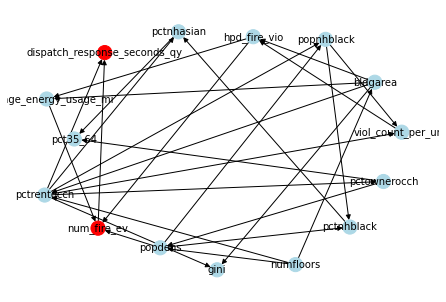

<Figure size 864x720 with 0 Axes>

In [229]:
import networkx as nx
import pylab as plt
fig = plt.gcf()

values = ['red' if n in ['num_fire_ev', 'dispatch_response_seconds_qy'] else 'lightblue' for n in model.nodes()]
# use networkx to draw DAG
nx.draw(model, node_color=values, with_labels=True, font_color='black', node_size=200,font_size=10)

plt.figure(figsize = (12,10))
fig.savefig('dag_.png')

In [230]:
pred = model.predict(test.loc[:, [n for n in model.nodes() if n not in ['num_fire_ev', 'dispatch_response_seconds_qy']]])
print(pred)

  0%|          | 0/2786 [00:00<?, ?it/s]

      num_fire_ev  dispatch_response_seconds_qy
0               3                             1
1               2                             2
2               2                             3
3               0                             0
4               0                             0
...           ...                           ...
3255            3                             1
3256            0                             0
3257            0                             0
3258            3                             3
3259            0                             0

[3260 rows x 2 columns]


In [231]:
for i in impt_vars[0:2]:
    print("\nOS accuracy for: {}".format(i))
    print((pred[i].reset_index(drop = True) == test[i].reset_index(drop = True)).mean())


OS accuracy for: dispatch_response_seconds_qy
0.36779141104294477

OS accuracy for: num_fire_ev
0.4852760736196319


In [232]:
# prediction just for time to the fire
pred = model.predict(test.loc[:, [n for n in model.nodes() if n not in ['dispatch_response_seconds_qy']]], stochastic = True)
print(pred)

  0%|          | 0/2950 [00:00<?, ?it/s]

       dispatch_response_seconds_qy
2261                              2
1859                              2
5182                              2
5343                              3
6263                              1
...                             ...
3325                              1
4919                              0
6346                              3
2351                              2
10018                             1

[3260 rows x 1 columns]


In [233]:
print("\nOS accuracy time to the fire, includes num_fire_ev as predictor")
print((pred['dispatch_response_seconds_qy'].reset_index(drop = True) == test['dispatch_response_seconds_qy'].reset_index(drop = True)).mean())


OS accuracy time to the fire, includes num_fire_ev as predictor
0.3196319018404908


### PC Method for Causal Model calculations

In [234]:
from pgmpy.estimators import PC
from pgmpy.estimators.CITests import chi_square

In [252]:
# create test train split for testing DAG
train, test = train_test_split(df_box_disc.loc[:, ['num_fire_ev', 'popdens', 'hpd_b_c_vio', 'bldgarea', 'unitsres']], test_size=0.3, random_state=999)
#train, test = train_test_split(df_box_disc.loc[:, impt_vars[-10:-1]], test_size=0.3, random_state=999)
train.head()

,num_fire_ev,popdens,hpd_b_c_vio,bldgarea,unitsres
2058,0,1,1,1,1
5077,2,0,2,0,0
5775,2,2,2,0,1
5959,1,1,0,2,0
6683,1,3,2,2,3


In [253]:
pc_est = PC(train)

# Step 1: construct undirected skeleton
skel, separating_sets = pc_est.build_skeleton(significance_level=0.01)
print("Undirected edges: ", skel.edges())

  0%|          | 0/5 [00:00<?, ?it/s]

Undirected edges:  [('num_fire_ev', 'popdens'), ('num_fire_ev', 'hpd_b_c_vio'), ('num_fire_ev', 'bldgarea'), ('popdens', 'hpd_b_c_vio'), ('popdens', 'bldgarea'), ('popdens', 'unitsres'), ('hpd_b_c_vio', 'bldgarea'), ('hpd_b_c_vio', 'unitsres'), ('bldgarea', 'unitsres')]


In [254]:
# Step 2: partially directed acyclic graph 
pdag = pc_est.skeleton_to_pdag(skel, separating_sets)
print("PDAG edges:       ", pdag.edges())

PDAG edges:        [('num_fire_ev', 'hpd_b_c_vio'), ('num_fire_ev', 'popdens'), ('num_fire_ev', 'bldgarea'), ('hpd_b_c_vio', 'unitsres'), ('hpd_b_c_vio', 'bldgarea'), ('hpd_b_c_vio', 'popdens'), ('hpd_b_c_vio', 'num_fire_ev'), ('unitsres', 'hpd_b_c_vio'), ('unitsres', 'bldgarea'), ('unitsres', 'popdens'), ('popdens', 'num_fire_ev'), ('popdens', 'hpd_b_c_vio'), ('popdens', 'unitsres'), ('popdens', 'bldgarea'), ('bldgarea', 'unitsres'), ('bldgarea', 'num_fire_ev'), ('bldgarea', 'popdens'), ('bldgarea', 'hpd_b_c_vio')]


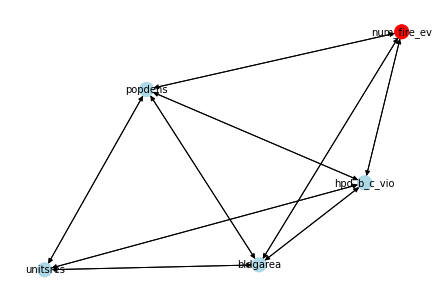

<Figure size 864x720 with 0 Axes>

In [255]:
fig = plt.gcf()

values = ['red' if n in ['num_fire_ev'] else 'lightblue' for n in pdag.nodes()]
# use networkx to draw DAG
nx.draw(pdag, node_color=values, with_labels=True, font_color='black', node_size=200,font_size=10)

plt.figure(figsize = (12,10))
fig.savefig('pdag_box.png')

In [256]:
model = pc_est.estimate()
print("DAG edges:        ", model.edges())

  0%|          | 0/5 [00:00<?, ?it/s]

DAG edges:         [('hpd_b_c_vio', 'num_fire_ev'), ('hpd_b_c_vio', 'popdens'), ('unitsres', 'popdens'), ('unitsres', 'hpd_b_c_vio'), ('popdens', 'num_fire_ev'), ('bldgarea', 'num_fire_ev'), ('bldgarea', 'popdens'), ('bldgarea', 'hpd_b_c_vio'), ('bldgarea', 'unitsres')]


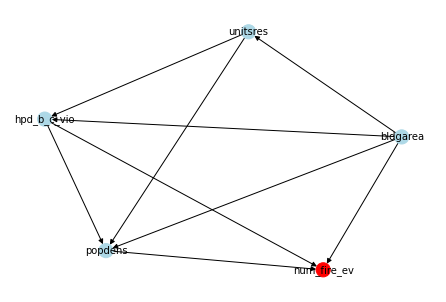

<Figure size 864x720 with 0 Axes>

In [257]:
fig = plt.gcf()

values = ['red' if n in ['num_fire_ev'] else 'lightblue' for n in model.nodes()]
# use networkx to draw DAG
nx.draw(model, node_color=values, with_labels=True, font_color='black', node_size=200,font_size=10)

plt.figure(figsize = (12,10))
fig.savefig('model_pdag_est_box.png')